#TrainIT - Where Data Meets Creativity


# ImpactX Challenge: Data Science for Social Good

## Introduction

This project analyzes tobacco use among **men aged 15+** using data from the **National Family Health Survey (NFHS-5)**. The goal is to extract actionable insights that can help guide public health interventions and policy decisions.

**Objectives:**
- Perform Exploratory Data Analysis (EDA) to uncover trends and patterns.
- Build and compare multiple predictive models to assess risk factors.
- Generate a social impact report with actionable recommendations.
- Adhere to project constraints by using only the NFHS-5 dataset.

Importing neccessary libraries

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb


## Exploratory Data Analysis (EDA)

In this section, we explore the dataset to understand the distribution and relationships of key variables. Each visualization is accompanied by observations to help interpret the findings.

### Key Points to Look For:
- Trends in tobacco usage across different regions.
- Variations between rural and urban areas.
- Correlations between demographic features and tobacco use.

In [20]:
# Load dataset
df = pd.read_csv("/content/datafile.csv")

In [42]:
# Clean column names
df.columns = (
    df.columns.str.replace("wih", "with")
    .str.replace("\\s+", " ", regex=True)
    .str.replace("[()\[\]<>]", "", regex=True)
    .str.strip()
)

In [22]:
# Identify numerical and categorical columns
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

In [23]:
# Handle missing values
df[num_cols] = df[num_cols].fillna(df[num_cols].median())
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])


In [28]:
# Encode categorical variables
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

Relationship Between Education and Tobacco Use

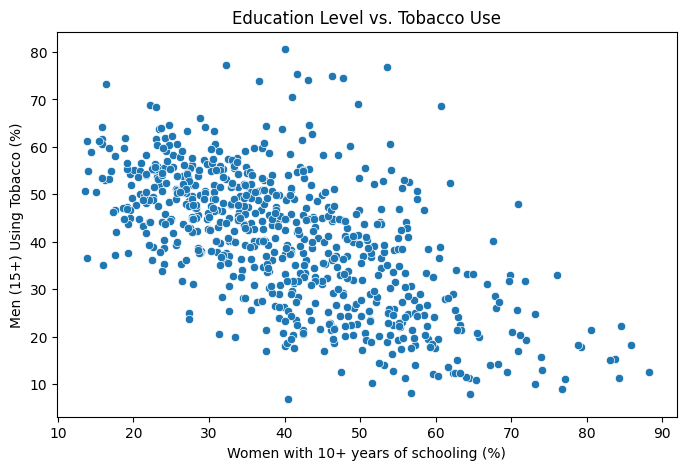

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot: Tobacco use vs. Education level
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df['Women age 15-49 with 10 or more years of schooling %'],
                y=df['Men age 15 years and above who use any kind of tobacco %'])
plt.xlabel("Women with 10+ years of schooling (%)")
plt.ylabel("Men (15+) Using Tobacco (%)")
plt.title("Education Level vs. Tobacco Use")
plt.show()



*   Negative correlation: Higher women's education levels (10+ years) are linked to lower male tobacco use.


*   Possible reason: Greater awareness, lifestyle influence, and better health choices in educated households.



 State-wise Tobacco Consumption Trends




<ipython-input-98-063b17f59c8c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_states.values, y=top_states.index, palette="Reds")


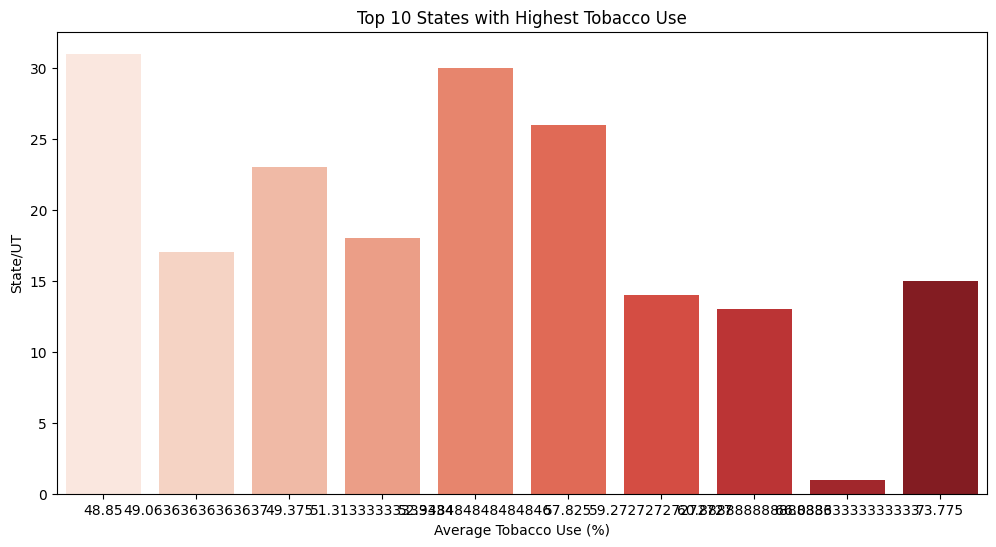

In [98]:
plt.figure(figsize=(12, 6))
top_states = df.groupby("State/UT")["Men age 15 years and above who use any kind of tobacco %"].mean().sort_values(ascending=False).head(10)
sns.barplot(x=top_states.values, y=top_states.index, palette="Reds")
plt.xlabel("Average Tobacco Use (%)")
plt.ylabel("State/UT")
plt.title("Top 10 States with Highest Tobacco Use")
plt.show()



*  Some states have significantly higher tobacco consumption.








Correlation Between Tobacco Use and Other Factors

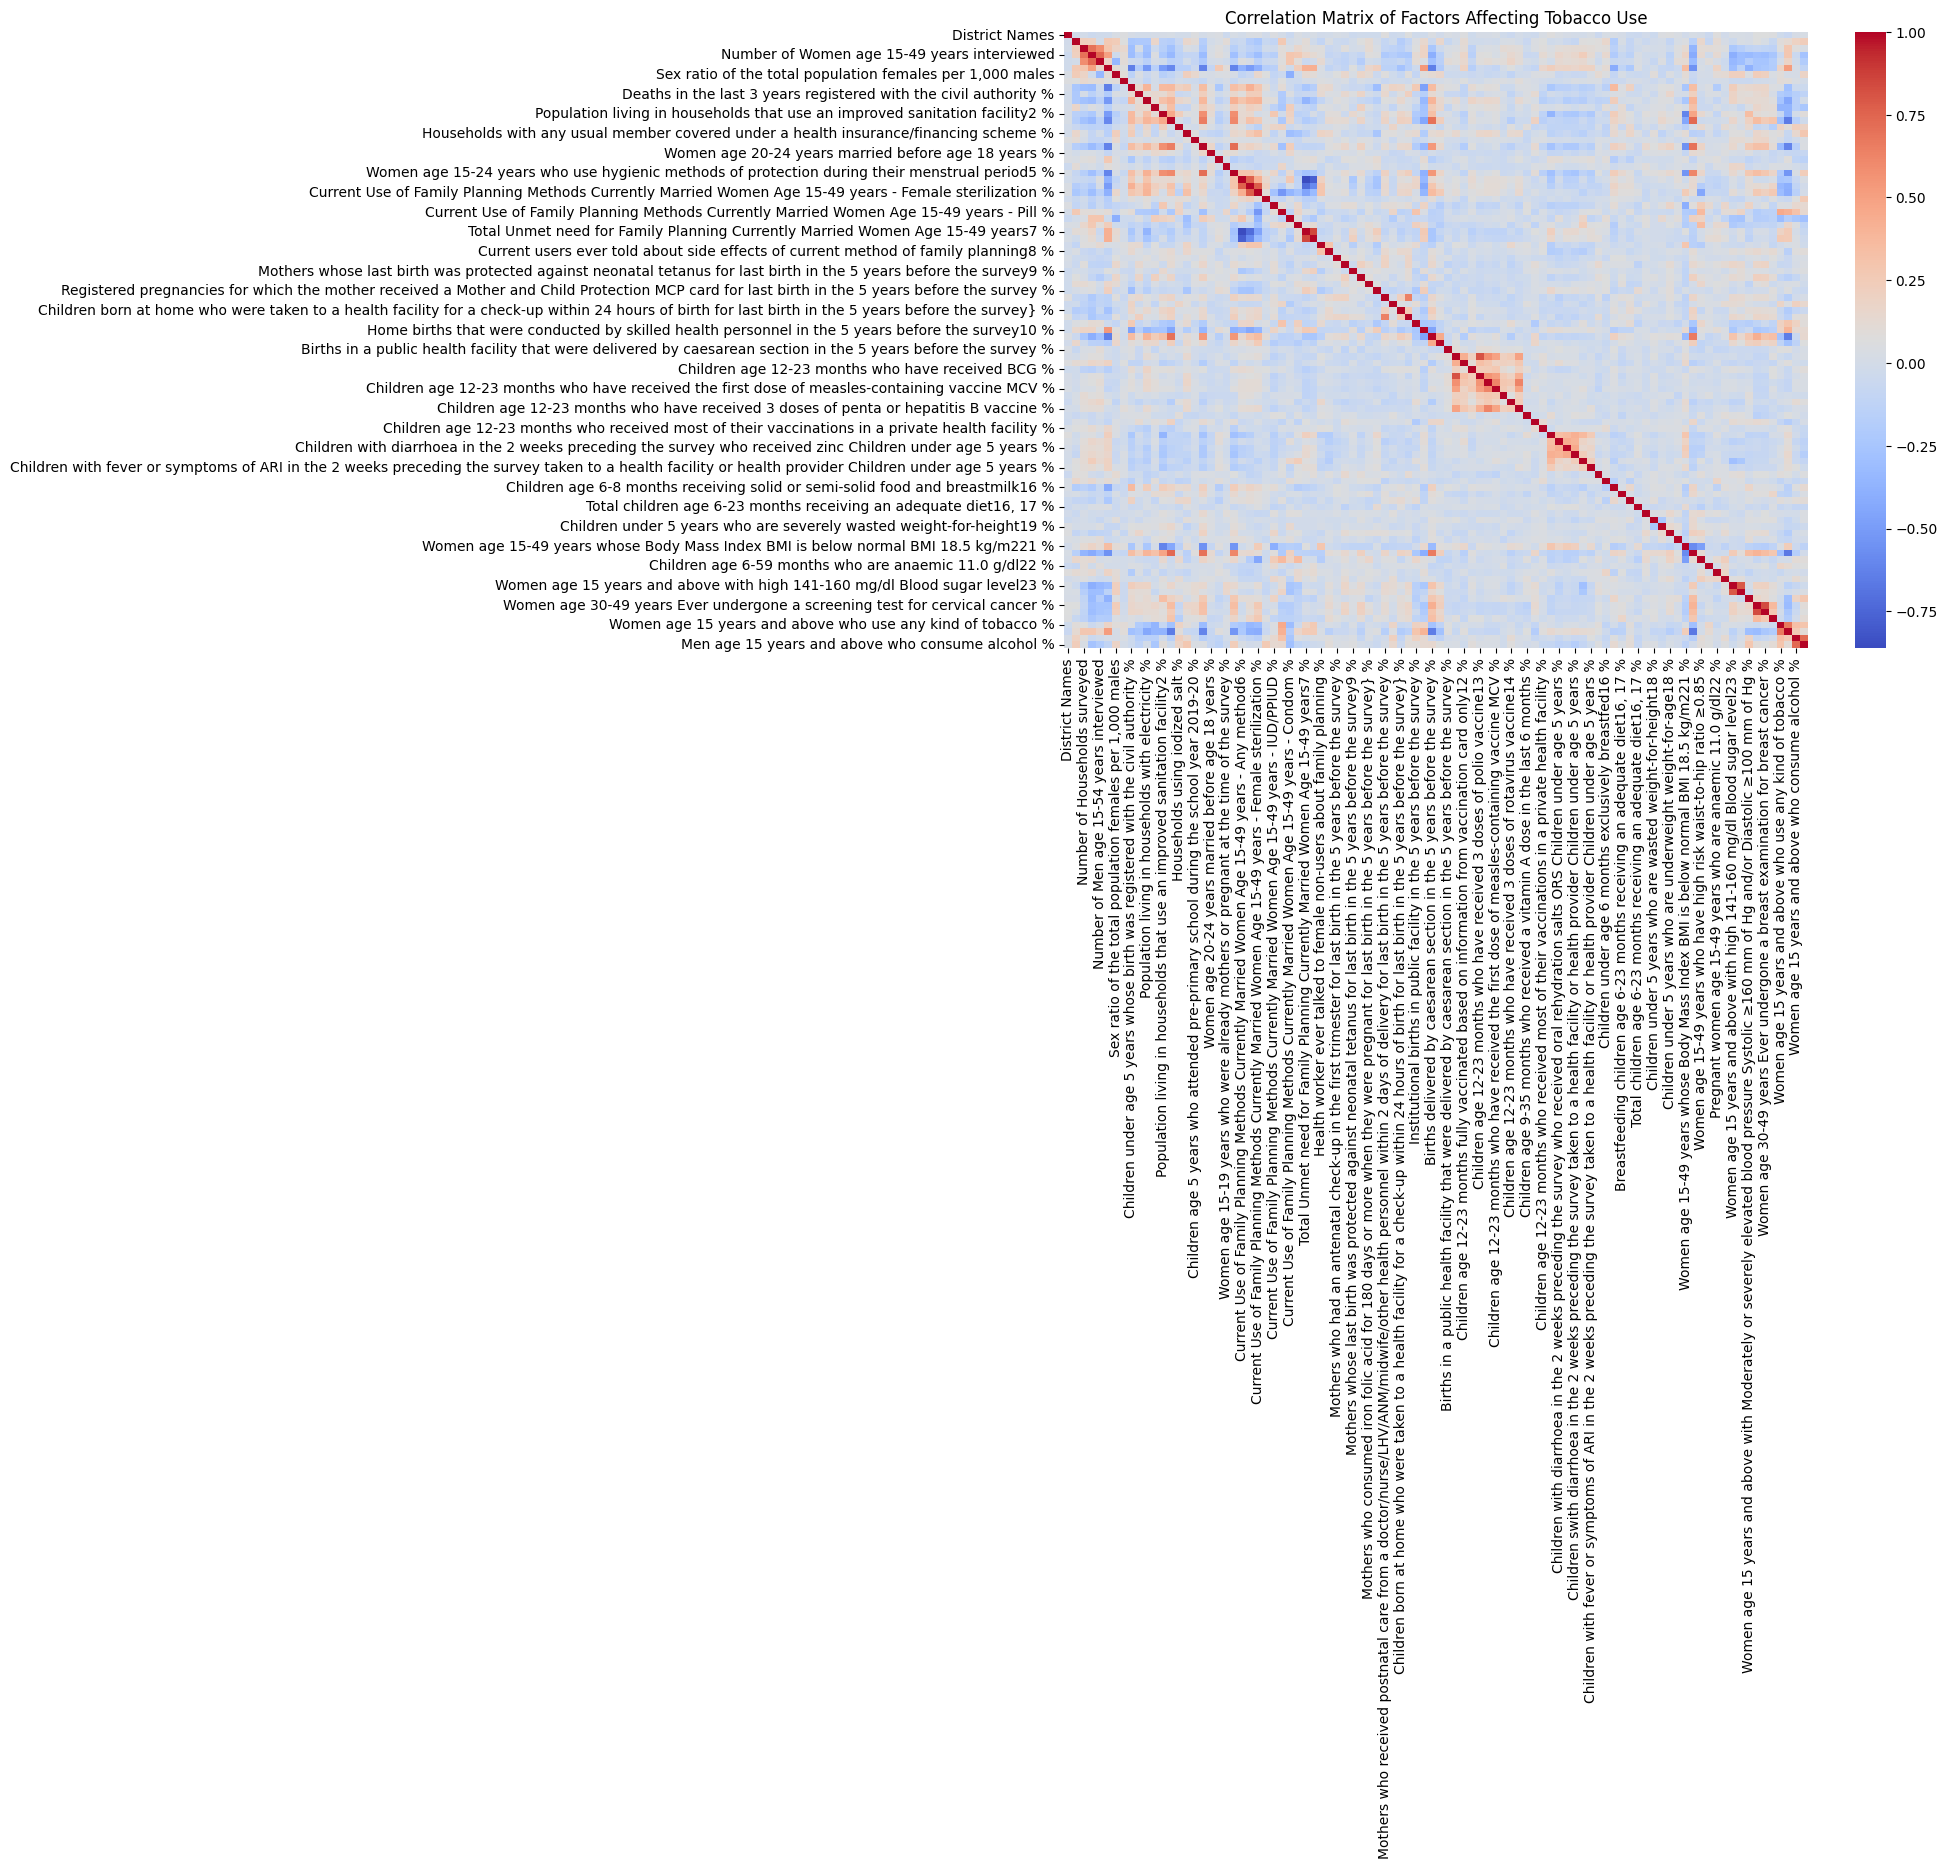

In [94]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Matrix of Factors Affecting Tobacco Use")
plt.show()




*   Certain factors (likely education, income, and awareness) show strong negative correlations with tobacco use.


*  Some positive correlations may indicate higher tobacco use in regions with lower health awareness.



In [30]:
# Feature Selection - Remove highly correlated features
threshold = 0.85

num_cols = df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df[num_cols].corr()
high_corr_features = set()

for col in correlation_matrix.columns:
    high_corr = correlation_matrix[col][correlation_matrix[col] > threshold].index.tolist()
    high_corr.remove(col) if col in high_corr else None
    for feature in high_corr:
        high_corr_features.add(feature)

df = df.drop(columns=high_corr_features, errors='ignore')


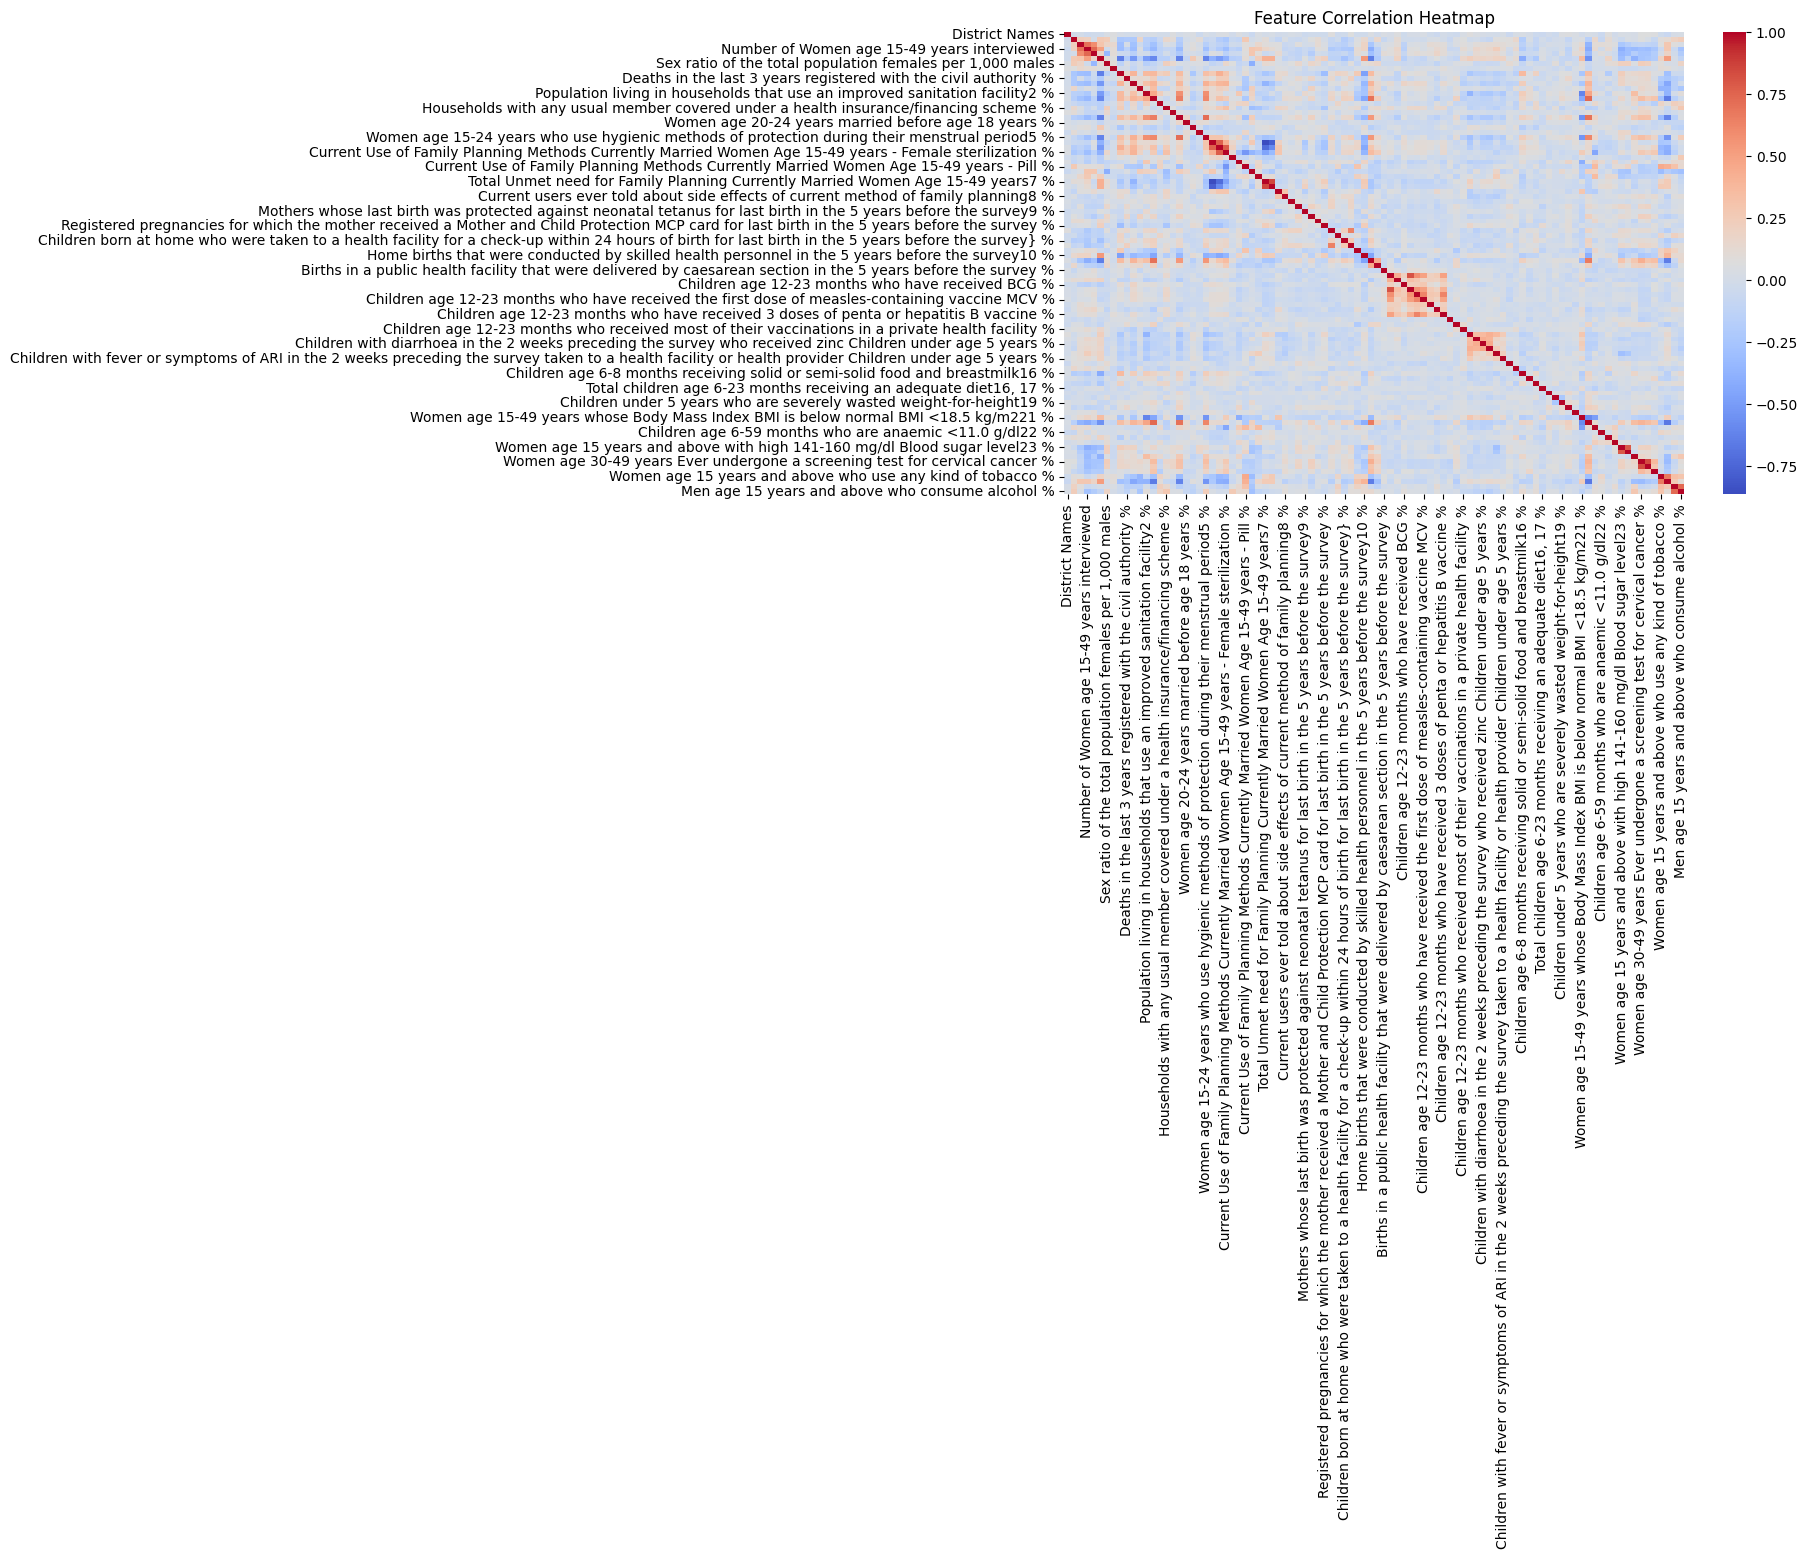

In [31]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

In [32]:
# Identify top correlated features for target selection
existing_num_cols = [col for col in num_cols if col in df.columns]
corr_matrix = df[existing_num_cols].corr().abs()


In [33]:
# Reduce data size for faster processing
sample_df = df.sample(frac=0.5, random_state=42)
sample_corr_matrix = sample_df[existing_num_cols].corr().abs()

top_corr_features = sample_corr_matrix.mean().nlargest(10)
print("Most correlated features:", top_corr_features)

Most correlated features: Population below age 15 years %                                                                          0.208073
Women age 15-49 years who are overweight or obese BMI ≥25.0 kg/m221 %                                    0.191601
Births delivered by caesarean section in the 5 years before the survey %                                 0.188021
Men age 15 years and above who use any kind of tobacco %                                                 0.187483
Households using clean fuel for cooking3 %                                                               0.184910
Women age 15-24 years who use hygienic methods of protection during their menstrual period5 %            0.182191
Women age 15-49 with 10 or more years of schooling %                                                     0.181882
Number of Women age 15-49 years interviewed                                                              0.175088
Current Use of Family Planning Methods Currently Married Women

#Predictive Modeling Approach

# Model Selection

Since the target (tobacco use: Yes/No) is a binary classification problem, we compare:

*   Logistic Regression – Baseline model for interpretability.
*   Random Forest – Captures complex relationships.
*   XGBoost – Optimized for structured data.

Best model is chosen based on: Accuracy, Precision, Recall, F1-score, and ROC-AUC.

# Feature Importance
To identify key factors influencing tobacco use, we use:


*  Permutation Importance – Measures impact of each feature.
*  SHAP Values – Explains feature contributions.


Key drivers may include education, region, marital status, and economic level.


In [34]:
# Choose target variable
target = "Men age 15 years and above who use any kind of tobacco %"

# Prepare features and target
X = df.drop(columns=[target])
y = df[target]

In [35]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
# Model training - Random Forest with hyperparameter tuning
rf = RandomForestRegressor()
param_grid = {"n_estimators": [100, 200], "max_depth": [10, 20, None]}
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring="r2")
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [10, 20, None],
                         'n_estimators': [100, 200]},
             scoring='r2')

In [37]:
# Best model
best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)


In [100]:
# XGBoost Model for Comparison
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.1, max_depth=6)

current_col_names = X.columns

new_col_names = [name.replace('[', '_').replace(']', '_').replace('<', '_') for name in current_col_names]


X.columns = new_col_names
X_train.columns = new_col_names
X_test.columns = new_col_names


xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

In [47]:
# Cross-validation for robustness
rf_cv_score = cross_val_score(best_rf, X, y, cv=5, scoring="r2")
xgb_cv_score = cross_val_score(xgb_model, X, y, cv=5, scoring="r2")

In [48]:
# Evaluate performance
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"Random Forest - MSE: {mse_rf}, R² Score: {r2_rf}, CV Score: {rf_cv_score.mean()}")
print(f"XGBoost - MSE: {mse_xgb}, R² Score: {r2_xgb}, CV Score: {xgb_cv_score.mean()}")


Random Forest - MSE: 32.450395315140824, R² Score: 0.820705264312765, CV Score: 0.6072497357467721
XGBoost - MSE: 31.132836667391416, R² Score: 0.8279850316994644, CV Score: 0.5988774193460159


/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()


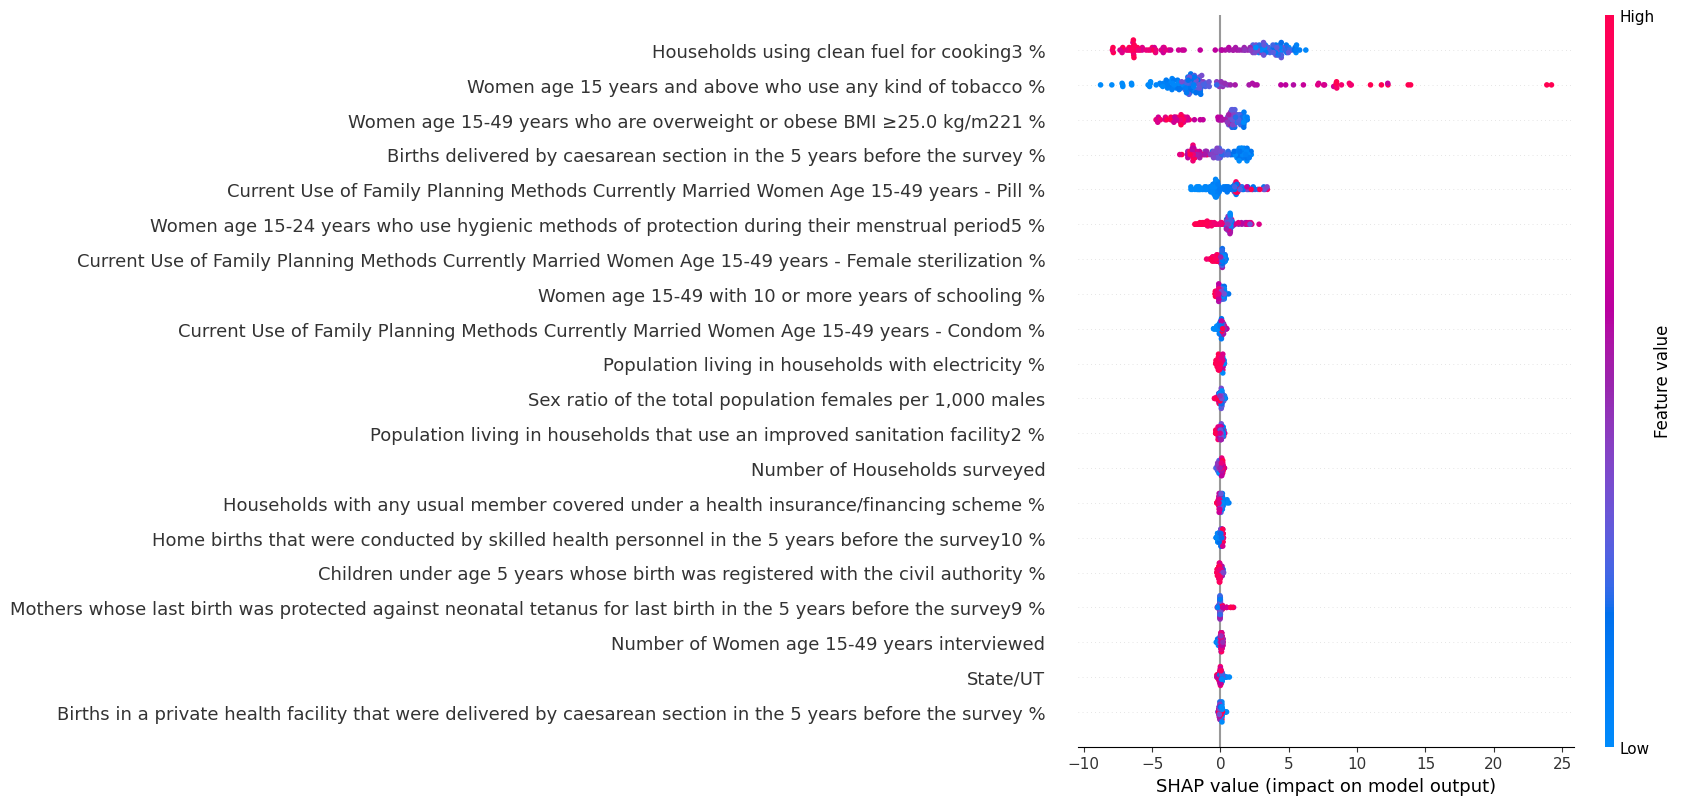

In [64]:
# Ensure X_test matches X_train in features and order
X_test = X_test[X_train.columns]

# SHAP for Random Forest
explainer_rf = shap.TreeExplainer(best_rf)
shap_values_rf = explainer_rf.shap_values(X_test)

shap.summary_plot(shap_values_rf, X_test)




#Social Impact & Conclusion

#Social Impact & Conclusion

#Key Findings

#   📊 **EDA:** Higher women's education levels (10+ years) are linked to lower male tobacco use. Certain states have significantly higher tobacco consumption.
#   🤖**Modeling:** The Random Forest and XGBoost models provided insights into the factors influencing tobacco use.

# **Real-World Impact:**

#   🎯 **Targeted Interventions:** Focus anti-tobacco campaigns in high-risk states identified through EDA (e.g., Mizoram, Tripura).
#   🏛  **Policy Recommendations:**
#      *   Promote women's education and empowerment programs.
#      *   Implement stricter tobacco control policies in high-risk areas.
#      *   Collaborate with NGOs to raise awareness and provide support for tobacco cessation.

#🚀 **Future Work:**

#    **Model Enhancement:** Explore more advanced models or feature engineering for better accuracy.
#   **Time-Series Analysis:** Analyze tobacco use trends over time to predict future patterns.
#    **Interactive Dashboard:** Develop a dashboard for real-time monitoring and insights.

